In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

warnings.filterwarnings("ignore")
np.set_printoptions(precision=3)
pd.set_option('precision', 3)

### Клиенты телекоммуникационной компании 

У вас есть набор данных от некой телекоммуникационной компании. Данные содержат информацию о пользователях компании, их демографических характеристиках, услугах, которыми они пользуются, продолжительности пользования услугами компании, способе оплаты и размере оплаты.

Задача состоит в том, чтобы проанализировать данные и спрогнозировать отток пользователей (выявить людей, которые будут и не будут продлевать свой контракт с компанией).


Gender - пол (male / female) <br>
Senior - пенсионер или нет (1, 0)<br>
Married - состоит ли в браке (Yes, No) <br>
Tenure - сколько месяцев человек является клиентом компании<br>
Phone - подключен ли телефон (Yes, No)<br>
MultiplePhone - подключено ли несколько телефонных каналов (Yes, No, No phone service)<br>
Internet - предоставляются ли услуги интернет соединения (DSL, Fiber optic, No)<br>
Security - подключен ли сервис интернет-безопасности (Yes, No, No internet service)<br>
Backup - активирована ли служба онлайн-резервного копирования (Yes, No, No internet service)<br>
Insurance - есть ли у клиента страховка оборудования (Yes, No, No internet service)<br>
Support - подключена ли служба технической поддержки (Yes, No, No internet service)<br>
TV - подключена ли служба потокового телевидения (Yes, No, No internet service)<br>
Movies - активирован ли сервис потокового кино (Yes, No, No internet service)<br>
Contract - тип клиентского контракта (Month-to-month, One year, Two year)<br>
EBilling - использует ли клиент безбумажный биллинг (Yes, No)<br>
PaymentMethod - способ оплаты (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))<br>
MonthlyCharges - текущий ежемесячный платеж<br>
TotalCharges - общая сумма, которую клиент заплатил за услуги за все время<br>
Churn - покинул ли клиент компанию (Yes or No)<br>


In [2]:
test_data = pd.read_csv('test.csv', index_col=0)
data = pd.read_csv('train.csv', index_col=0)
data.head(5)

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,Insurance,Support,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
Index,,,,,,,,,,,,,,,,,,,,
0,Female,0,Yes,Yes,67,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),54.20,3623.95,False
1,Female,0,No,No,34,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Mailed check,64.40,2088.75,True
2,Female,1,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,Yes,Bank transfer (automatic),96.60,6827.5,False
3,Female,0,Yes,Yes,63,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Mailed check,63.55,4014.2,False
4,Male,0,Yes,Yes,69,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,One year,No,Credit card (automatic),95.75,6511.25,False


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3591 entries, 0 to 3590
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          3591 non-null   object 
 1   Senior          3591 non-null   int64  
 2   Married         3591 non-null   object 
 3   Dependents      3591 non-null   object 
 4   Tenure          3591 non-null   int64  
 5   Phone           3591 non-null   object 
 6   MultiplePhones  3591 non-null   object 
 7   Internet        3591 non-null   object 
 8   Security        3591 non-null   object 
 9   Backup          3591 non-null   object 
 10  Insurance       3591 non-null   object 
 11  Support         3591 non-null   object 
 12  TV              3591 non-null   object 
 13  Movies          3591 non-null   object 
 14  Contract        3591 non-null   object 
 15  EBilling        3591 non-null   object 
 16  PaymentMethod   3591 non-null   object 
 17  MonthlyCharges  3591 non-null   f

# Поиск выбросов

In [4]:
# признак  | значения
def printValues(data = data):
    for col in data: #[['model', 'transmission', 'fuelType']]:
        values = data[col].unique()
        str_values = str(values)
        if len(str_values) > 300:
            str_values = str_values[:200] + '...'
        print(col, ':', len(values), '\n', str_values, '\n')
        
# printValues()

In [5]:
numeric_data = data.select_dtypes(include=np.number)
# numeric_data.sample(5)

In [6]:
# data.TotalCharges.value_counts().head(10)

In [7]:
data.TotalCharges = data.TotalCharges.replace(' ', 0).astype(float)
test_data.TotalCharges = test_data.TotalCharges.replace(' ', 0).astype(float)
# data.info()

In [8]:
#numeric_data = data.select_dtypes(include=np.number)
#numeric_data.sample(5)

In [9]:
# новые признаки
def add_priznak(data=data):
    data['MarriedDependents'] = ((data.Married == 'Yes') & (data.Dependents == 'Yes')) + 0

    data['SeniorDependents'] = ((data.Senior == 1) & (data.Dependents == 'Yes')) + 0
    
#    data['PaymentMethod_Mailed_check'] = (data.PaymentMethod == 'Mailed check') + 0
#    data['PaymentMethod_Electronic_check'] = (data.PaymentMethod == 'Electronic check') + 0
#    data['PaymentMethod_Card_automatic'] = (data.PaymentMethod == 'Credit card (automatic)') + 0
#    data['PaymentMethod_Transfer_automatic'] = (data.PaymentMethod == 'Bank transfer (automatic)') + 0
#    data.drop('PaymentMethod', inplace=True, axis=1)
   
    data['AverageCharges'] = (data.TotalCharges / data.Tenure).fillna(0)
    data['DiffCharges'] = (data.MonthlyCharges - (data.TotalCharges / data.Tenure)).fillna(0)
#    data['DiffChargesSign'] = ((data.MonthlyCharges - (data.TotalCharges / data.Tenure)).fillna(0) > 0) + 1

    data['Tenure_0'] = (data.Tenure == 0) + 0
#    data['Tenure_1'] = (data.Tenure == 1) + 0
#    data['Tenure_2'] = (data.Tenure == 2) + 0

add_priznak(data)
add_priznak(test_data)

In [10]:
replaces = {'Gender': {'Female': 1, 'Male': 0}, 
            'Married': {'Yes': 1, 'No': 0}, 
            'Dependents': {'Yes': 1, 'No': 0},
            
            'Phone': {'Yes': 1, 'No': 0}, 
            
            'Internet': {'Fiber optic': 2, 'DSL': 1, 'No': 0},
            
            
            'MultiplePhones': {'Yes': 2, 'No': 0, 'No phone service': 1}, 
            'Security': {'Yes': 2, 'No': 0, 'No internet service': 1}, 
            'Backup': {'Yes': 2, 'No': 0, 'No internet service': 1}, 
            'Insurance': {'Yes': 2, 'No': 0, 'No internet service': 1}, 
            'Support': {'Yes': 2, 'No': 0, 'No internet service': 1}, 
            'TV': {'Yes': 2, 'No': 0, 'No internet service': 1}, 
            'Movies': {'Yes': 2, 'No': 0, 'No internet service': 1}, 
            
            
            'Contract': {'Month-to-month': 1, 'One year': 12, 'Two year': 24}, 
            
            'EBilling': {'Yes': 1, 'No': 0},
            'PaymentMethod': {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}
           }
           
data = data.replace(replaces)
test_data = test_data.replace(replaces)

In [11]:
numeric_data = data.select_dtypes(include=np.number)
# numeric_data.sample(5)

In [12]:
data

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,...,EBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MarriedDependents,SeniorDependents,AverageCharges,DiffCharges,Tenure_0
Index,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,1,67,0,1,1,2,2,...,0,3,54.20,3623.95,False,1,0,54.089,0.111,0
1,1,0,0,0,34,1,2,1,2,2,...,1,1,64.40,2088.75,True,0,0,61.434,2.966,0
2,1,1,1,0,72,1,2,2,2,2,...,1,2,96.60,6827.50,False,0,0,94.826,1.774,0
3,1,0,1,1,63,1,0,1,2,2,...,0,1,63.55,4014.20,False,1,0,63.717,-0.167,0
4,0,0,1,1,69,1,2,2,0,2,...,0,3,95.75,6511.25,False,1,0,94.366,1.384,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3586,1,0,0,0,5,1,0,2,0,0,...,0,0,80.20,384.25,False,0,0,76.850,3.350,0
3587,1,0,1,1,71,1,0,1,2,0,...,0,3,77.55,5574.35,False,1,0,78.512,-0.962,0
3588,1,0,1,0,68,1,2,2,0,2,...,0,3,86.45,5762.95,False,0,0,84.749,1.701,0


<AxesSubplot:>

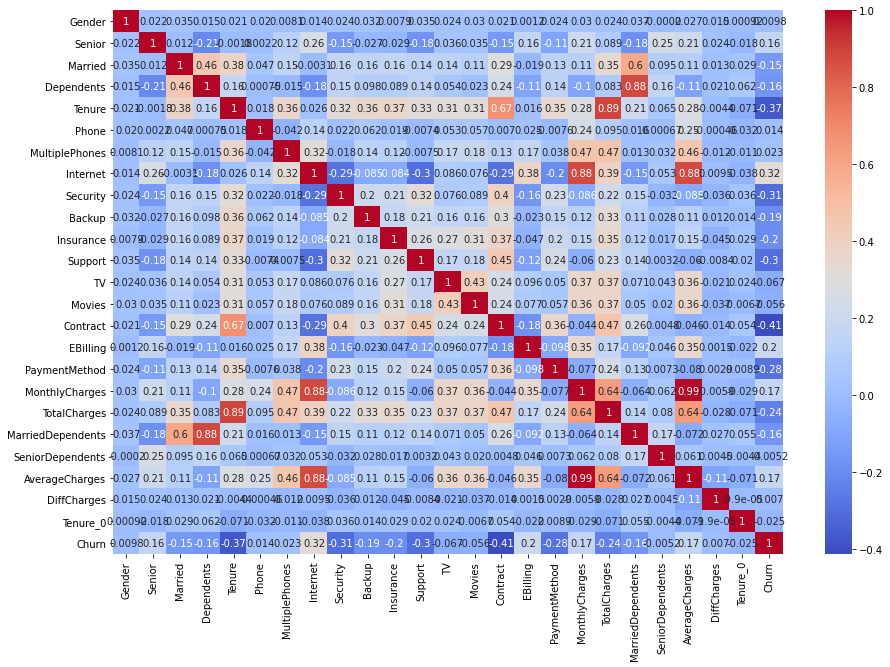

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(data[numeric_data.columns.tolist() + ['Churn']].corr(method = 'spearman'), cmap='coolwarm', annot = True)

# ВЫБОРКИ

In [14]:

X = numeric_data
Y = data.Churn

X_trains = []
X_tests = []
Y_trains = []
Y_tests = []
for i in range(1, 10):
    X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(X, Y,test_size = 0.5,random_state = i)
    X_trains.append(X_train_i)
    X_tests.append(X_test_i)
    Y_trains.append(Y_train_i)
    Y_tests.append(Y_test_i)

# МЕТЬЮСЫ 

In [15]:
def train_predict(algo, X_train, Y_train, X_test, threshold):
    fitted = algo().fit(X_train, Y_train)
    result = fitted.predict(X_test)
    if (threshold == None):
        return result
    else: 
        return result > threshold

def print_mathewses(algo, threshold = None):
    res = []
    for i in range(len(X_trains)):
        predict = train_predict(algo, X_trains[i], Y_trains[i], X_tests[i], threshold)
        res.append(matthews_corrcoef(Y_tests[i], predict))
    print("# min:", round(np.min(res), 5))
    print("# avg:", round(np.mean(res), 5))
    print("# max:", round(np.max(res), 5))
#    [print(r) for r in res]

In [16]:
# LassoCV
# print_mathewses(lambda: Lasso(), threshold = 0.5)

In [17]:
# LassoCV
# print_mathewses(lambda: LassoCV(), threshold = 0.5)
#avg: 0.40694
#min: 0.3808

In [18]:
# Ridge
# print_mathewses(lambda: RidgeCV(), threshold = 0.5)

In [19]:
# GradientBoostingClassifier
# print_mathewses(lambda: GradientBoostingClassifier(loss="exponential", subsample=0.8, max_depth=1, n_estimators=200, learning_rate=0.4, random_state=0, max_features="auto", tol=1e-10))

# 

In [20]:
# LogisticRegression
print_mathewses(lambda: LogisticRegression())

# min: 0.43988
# avg: 0.46636
# max: 0.49086


In [21]:
# LogisticRegression liblinear
print_mathewses(lambda: LogisticRegression(solver = "liblinear", random_state=10, intercept_scaling = 0.01))

# min: 0.43925
# avg: 0.46421
# max: 0.48585


In [22]:
# LogisticRegression multinomial
print_mathewses(lambda: LogisticRegression(random_state=10, multi_class = "multinomial"))

# min: 0.43045
# avg: 0.46835
# max: 0.49189


In [23]:
# LogisticRegression newton-cg
print_mathewses(lambda: LogisticRegression(solver = "newton-cg"))

# min: 0.45069
# avg: 0.46414
# max: 0.49578


# Посылка

In [24]:
result_algo = LogisticRegression(solver = "newton-cg")
result_algo.fit(X, Y)
result_predictions = result_algo.predict(test_data)

df = pd.DataFrame({'Churn': result_predictions})
df.to_csv('submission.csv', index_label="Index")